load a dataset

In [3]:
import pandas as pd
import numpy as np

In [5]:
hits_train = pd.read_csv("/inputdata/tutorial/train.csv")

In [6]:
hits_train.head()

,global_id,event_id,wire_id,energy_deposit,relative_time,label
0,0,0,0,0.000000e+00,0.000000,0
1,1,0,1,0.000000e+00,0.000000,0
2,2,0,2,0.000000e+00,0.000000,0
3,3,0,3,0.000000e+00,0.000000,0
4,4,0,4,1.178108e-08,22.224176,2


In [7]:
candidates = hits_train.loc[(hits_train.energy_deposit > 0)]
X = candidates[['energy_deposit','relative_time']].values
y = (candidates.label == 1).values

In [8]:
X.shape,y.shape

((1173167, 2), (1173167,))

In [9]:
y

array([False,  True, False, ..., False, False, False], dtype=bool)

train test split example

In [10]:
from sklearn.cross_validation import train_test_split

/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
train_data.shape, test_data.shape

((821216, 2), (351951, 2))

Visualize the data

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
train_labels

array([False, False, False, ..., False, False, False], dtype=bool)

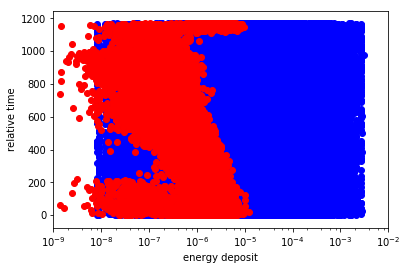

In [15]:
sig = np.where(train_labels==1)
bkg = np.where(train_labels==0)
plt.scatter(train_data[bkg,0], train_data[bkg,1], color='b')
plt.scatter(train_data[sig,0], train_data[sig,1], color='r')
plt.xscale('log')
plt.xlim(1e-9,1e-2)
plt.ylabel('relative time')
plt.xlabel('energy deposit')
plt.show()

example of decistion tree

In [16]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(train_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [17]:
from sklearn.metrics import accuracy_score
acc = accuracy_score( test_labels, rf.predict(test_data))
print acc*100,"% accuracy"

89.0751837614 % accuracy


PCA example for data transformation

In [18]:
from sklearn.decomposition import PCA

In [19]:
base = PCA(n_components=2)
base.fit(train_data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [20]:
new_data = base.transform(train_data)

In [21]:
new_data.shape

(821216, 2)

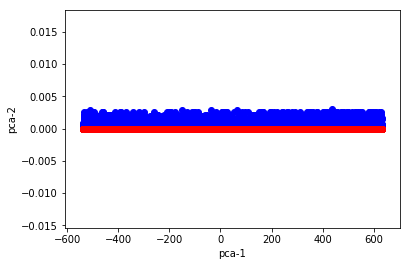

In [22]:
plt.scatter(new_data[bkg,0], new_data[bkg,1], color='b')
plt.scatter(new_data[sig,0], new_data[sig,1], color='r')
#plt.xscale('log')
#plt.xlim(1e-9,1e-2)
plt.ylabel('pca-2')
plt.xlabel('pca-1')
plt.show()

In [23]:
rf_2 = RandomForestClassifier()
rf_2.fit(new_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [24]:
new_test = base.transform(test_data)

In [25]:
acc_2 = accuracy_score( test_labels, rf_2.predict(new_test))
print acc_2*100,"% accuracy"

89.0748996309 % accuracy


we can do both in a pipeline

In [26]:
from sklearn.pipeline import Pipeline
pipe = Pipeline(steps=[('pca', base) , ('rf',RandomForestClassifier())])

pipe.fit( train_data, train_labels )

Pipeline(steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            m...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

In [27]:
acc_3 = accuracy_score( test_labels, rf_2.predict(test_data))
print acc_3*100,"% accuracy"

89.0748996309 % accuracy


example of cross validation. This may take a while

In [28]:
from sklearn.cross_validation import cross_val_score, KFold
scores = cross_val_score(pipe, train_data, train_labels, 
                         cv=KFold(train_data.shape[0],n_folds=20, random_state=42), 
                         scoring="accuracy")

In [29]:
print scores.mean(),scores.std()

0.890690142432 0.00131546608018


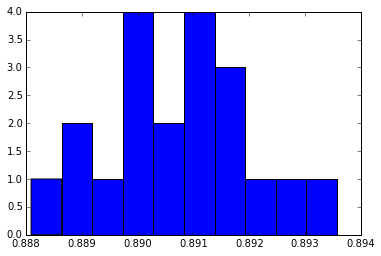

In [44]:
plt.hist( scores )
plt.xrange((0,1.)
plt.show()

example of grid search

have we used the best parameters for all

In [45]:
from sklearn.grid_search import GridSearchCV

In [49]:
grid = GridSearchCV(pipe,
                    param_grid={"pca__n_components": [1,2],
                                "rf__n_estimators": [5,10,20],
                                "rf__max_features": [0.1, 0.25, 0.5]
                                },
                    cv=KFold(train_data.shape[0],n_folds=20, random_state=42),
                    scoring='accuracy',
                    n_jobs=5,
                    verbose=1)

In [50]:
grid.fit(train_data, train_labels)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=821216, n_folds=20, shuffle=False, random_state=42),
       error_score='raise',
       estimator=Pipeline(steps=[('pca', PCA(copy=True, n_components=2, whiten=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params={}, iid=True, n_jobs=5,
       param_grid={'pca__n_components': [1, 2], 'rf__max_features': [0.1, 0.25, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [51]:
print grid.best_params_

{'pca__n_components': 2, 'rf__max_features': 0.1}


Kmeans example with cluster # search ?

much more at http://scikit-learn.org 